<a href="https://colab.research.google.com/github/ekaratnida/Applied-machine-learning/blob/master/Week12-SVM/SVM-Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converged at epoch 171
Loss: 0.10877758052970042
Accuracy: 1.0
w, b: [array([0.43983144, 0.14828998]), 0.05100000000000003]


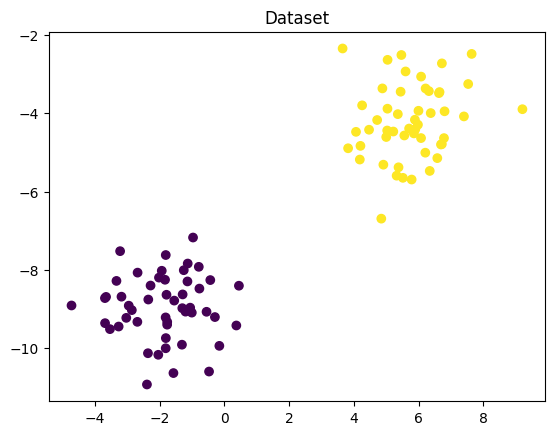

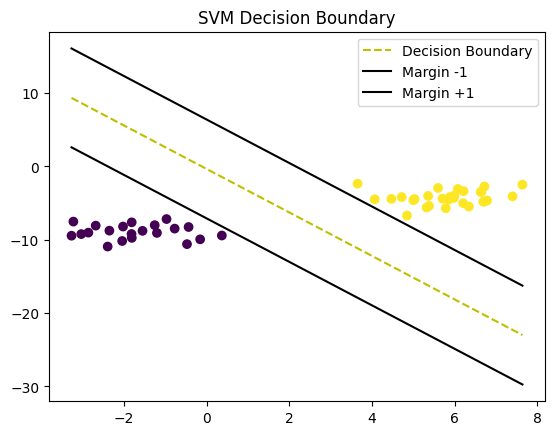

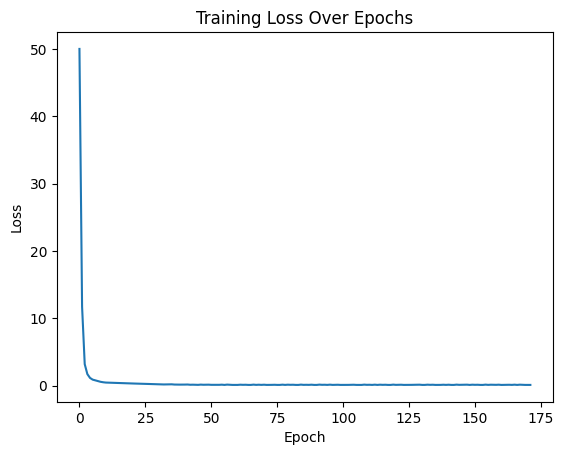

In [1]:
# -*- coding: utf-8 -*-
"""Improved SVM Implementation"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SVM:
    def __init__(self, C=1.0):
        self.C = C
        self.w = None
        self.b = None

    def hingeloss(self, w, b, X, y):
        """Compute hinge loss for all samples"""
        reg = 0.5 * np.dot(w, w.T)  # Regularization term: 1/2 ||w||^2
        loss = reg
        for i in range(X.shape[0]):
            opt_term = y[i] * (np.dot(w, X[i]) + b)
            loss += self.C * max(0, 1 - opt_term)
        return loss

    def fit(self, X, y, batch_size=100, learning_rate=0.001, epochs=2000, tol=1e-4):
        n_features = X.shape[1]
        n_samples = X.shape[0]

        # Initialize weights and bias
        self.w = np.zeros(n_features)
        self.b = 0
        losses = []

        ids = np.arange(n_samples)

        for epoch in range(epochs):
            np.random.shuffle(ids)  # Shuffle samples
            loss = self.hingeloss(self.w, self.b, X, y)
            losses.append(loss)

            # Early stopping
            if len(losses) > 1 and abs(losses[-1] - losses[-2]) < tol:
                print(f"Converged at epoch {epoch}")
                break

            for batch_start in range(0, n_samples, batch_size):
                grad_w = self.w.copy()  # Include regularization gradient
                grad_b = 0
                batch_size_actual = min(batch_size, n_samples - batch_start)

                for j in range(batch_start, batch_start + batch_size_actual):
                    idx = ids[j]
                    ti = y[idx] * (np.dot(self.w, X[idx]) + self.b)
                    if ti < 1:  # Only update gradients for misclassified or margin-violating points
                        grad_w -= self.C * y[idx] * X[idx]
                        grad_b -= self.C * y[idx]

                # Average gradients over batch
                grad_w /= batch_size_actual
                grad_b /= batch_size_actual

                # Update weights and bias
                self.w -= learning_rate * grad_w
                self.b -= learning_rate * grad_b

        return self.w, self.b, losses

    def predict(self, X):
        """Predict class labels (-1 or 1)"""
        scores = np.dot(X, self.w) + self.b
        return np.where(scores >= 0, 1, -1)

# Dataset
X, y = datasets.make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1, random_state=40)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train SVM
svm = SVM(C=1.0)
w, b, losses = svm.fit(X_train, y_train, batch_size=10, learning_rate=0.01, epochs=2000)

# Evaluate
predictions = svm.predict(X_test)
print("Loss:", losses[-1])
print("Accuracy:", accuracy_score(y_test, predictions))
print("w, b:", [w, b])

# Visualization
def visualize_dataset():
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Dataset")
    plt.show()

def visualize_svm(w, b, X_test, y_test):
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x - b + offset) / (w[1] + 1e-10)  # Avoid division by zero

    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
    x0_1, x0_2 = np.amin(X_test[:, 0]), np.amax(X_test[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)
    x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_m = get_hyperplane_value(x0_2, w, b, -1)
    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    plt.plot([x0_1, x0_2], [x1_1, x1_2], "y--", label="Decision Boundary")
    plt.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k", label="Margin -1")
    plt.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k", label="Margin +1")
    plt.legend()
    plt.title("SVM Decision Boundary")
    plt.show()

visualize_dataset()
visualize_svm(w, b, X_test, y_test)

# Plot loss
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()